## A4

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# draw some x points
n = 30
np.random.seed(1)
x = np.random.uniform(size=n)
x.sort()

# simulate y data
f = lambda x: 4 * np.sin(np.pi*x) * np.cos(6*np.pi*x**2)
y = np.random.normal(f(x), 1)

In [14]:
class KernelRidgeRegressor():
    
    def __init__(self, kernel, param=1, lam=1):
        self.kernel = kernel
        self.param = param
        self.lam = lam
        
    def train(self, x, y, cv=10, param_range=None, lambdas=None, seed=1):
        
        # dictionary to save error as function of parameters
        errs = dict()
        
        # perform cross validation
        if cv:
            # how many points in each fold
            fold_len = len(x)//cv
            # randomly shuffle points
            idx = np.random.permutation(len(x))
            x_, y_ = x[idx], y[idx]
            
            # loop over the kernel parameter and lambda
            for param in param_range:
                for lam in lambdas:
                    se = 0 # variable to collect square error
                    # loop over the folds
                    for i in range(cv):
                        # draw training and test folds
                        xtrain, ytrain = x_[:-fold_len], y_[:-fold_len]
                        xtest, ytest = x_[-fold_len:], y_[-fold_len:]
                        # create the kernel matrix from the training data
                        K = self.kernel(*np.meshgrid(xtrain,xtrain), param)
                        # solve for alpha
                        alpha = np.linalg.solve((K + lam*np.identity(len(xtrain))), ytrain)
                        # use alpha and the kernel to calculate f_hat
                        fhat = np.vectorize(lambda z: alpha.dot(self.kernel(xtrain, z, param)))
                        # record sq error for the fold
                        se += np.mean((ytest - fhat(xtest))**2)
                        # roll points to prepare for the next fold
                        x_, y_ = np.roll(x_, fold_len), np.roll(y_, fold_len)
                    # save mean sq error for these parameter values
                    errs[(param,lam)] = se/len(x)
            # get the param and lambda corresponding to the lowest MSE
            self.param, self.lam = min(errs, key=errs.get)
        
        # set up the predict method using this data
        K = self.kernel(*np.meshgrid(x,x), self.param)
        alpha = np.linalg.solve((K + self.lam*np.identity(len(x))), y)
        self.predict = np.vectorize(lambda z: alpha.dot(self.kernel(x, z, self.param)))
        
    def plot_kernel(self, xmin=0, xmax=1, N=100):
        x = np.linspace(xmin, xmax, N)
        K = self.kernel(*np.meshgrid(x,x), self.param)
        plt.imshow(K)

In [15]:
# create a polynomial kernel ridge regressor
poly_kernel = KernelRidgeRegressor(lambda x, z, d: (1 + x*z)**d)
poly_kernel.train(x, y,
                  cv = len(x),
                  param_range = np.arange(1, 30, 1), 
                  lambdas = np.logspace(-6, 6, 13))
print(f'poly -- {poly_kernel.param:.2f}  {poly_kernel.lam}')

# create an RBF kernel ridge regressor
rbf_kernel = KernelRidgeRegressor(lambda x, z, gamma: np.exp(-gamma*(x-z)**2))
rbf_kernel.train(x, y,
                 cv = len(x),
                 param_range = np.linspace(1, 80, 100), 
                 lambdas = np.logspace(-6, 6, 13))
print(f'rbf  -- {rbf_kernel.param:.2f}  {rbf_kernel.lam}')

poly -- 18.00  0.0001
rbf  -- 35.31  0.001


In [16]:
poly_bootstrap = []
rbf_bootstrap = []

grid = np.linspace(0, 1, 100)

B = 300
for i in range(B):
    
    idx = np.random.randint(len(x), size=len(x))
    x_, y_ = x[idx], y[idx]

    poly_kernel.train(x_, y_, cv=False)
    poly_bootstrap.append(poly_kernel.predict(grid))
    
    rbf_kernel.train(x_, y_, cv=False)
    rbf_bootstrap.append(rbf_kernel.predict(grid))

poly_5 = np.percentile(poly_bootstrap, 5, axis=0)
poly_95 = np.percentile(poly_bootstrap, 95, axis=0)

rbf_5 = np.percentile(rbf_bootstrap, 5, axis=0)
rbf_95 = np.percentile(rbf_bootstrap, 95, axis=0)

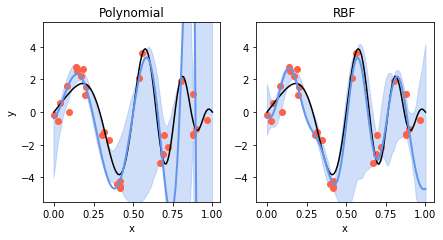

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.3))

ax1.plot(grid, f(grid), c='k')
ax1.plot(grid, poly_kernel.predict(grid), c='cornflowerblue', lw=2)
ax1.fill_between(grid, poly_5, poly_95, color='cornflowerblue', alpha=0.3)
ax1.scatter(x, y, c='tomato')

ax2.plot(grid, f(grid), c='k')
ax2.plot(grid, rbf_kernel.predict(grid), c='cornflowerblue', lw=2)
ax2.fill_between(grid, rbf_5, rbf_95, color='cornflowerblue', alpha=0.3)
ax2.scatter(x, y, c='tomato')

ax1.set(ylim = (-5.5, 5.5),
        xlabel = 'x', 
        ylabel = 'y',
        title = 'Polynomial')
ax2.set(ylim = (-5.5, 5.5),
        xlabel = 'x',
        title = 'RBF')

fig.savefig('A4b.pdf')

In [18]:
n = 300
np.random.seed(1)
x = np.random.uniform(size=n)
x.sort()
y = np.random.normal(f(x), 1)

In [21]:
# create a polynomial kernel ridge regressor
poly_kernel = KernelRidgeRegressor(lambda x, z, d: (1 + x*z)**d)
poly_kernel.train(x, y,
                  cv = 10,
                  param_range = np.arange(1, 30, 1), 
                  lambdas = np.logspace(-8, -1, 8))
print(f'poly -- {poly_kernel.param:.2f}  {poly_kernel.lam}')

# create an RBF kernel ridge regressor
rbf_kernel = KernelRidgeRegressor(lambda x, z, gamma: np.exp(-gamma*(x-z)**2))
rbf_kernel.train(x, y,
                 cv = 10,
                 param_range = np.linspace(1, 80, 100), 
                 lambdas = np.logspace(-6, 6, 13))
print(f'rbf  -- {rbf_kernel.param:.2f}  {rbf_kernel.lam}')

poly -- 23.00  1e-07
rbf  -- 18.56  1e-05


In [22]:
poly_bootstrap = []
rbf_bootstrap = []

grid = np.linspace(0, 1, 100)

B = 300
for i in range(B):
    
    idx = np.random.randint(len(x), size=len(x))
    x_, y_ = x[idx], y[idx]

    poly_kernel.train(x_, y_, cv=False)
    poly_bootstrap.append(poly_kernel.predict(grid))
    
    rbf_kernel.train(x_, y_, cv=False)
    rbf_bootstrap.append(rbf_kernel.predict(grid))

poly_5 = np.percentile(poly_bootstrap, 5, axis=0)
poly_95 = np.percentile(poly_bootstrap, 95, axis=0)

rbf_5 = np.percentile(rbf_bootstrap, 5, axis=0)
rbf_95 = np.percentile(rbf_bootstrap, 95, axis=0)

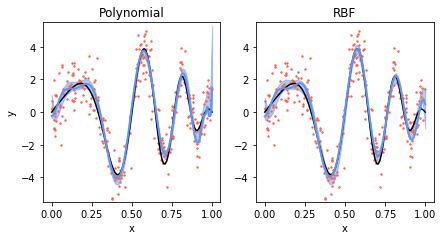

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.3))

ax1.plot(grid, f(grid), c='k')
ax1.plot(grid, poly_kernel.predict(grid), c='cornflowerblue', lw=2)
ax1.fill_between(grid, poly_5, poly_95, color='cornflowerblue', alpha=0.5)
ax1.scatter(x, y, c='tomato', s=2)

ax2.plot(grid, f(grid), c='k')
ax2.plot(grid, rbf_kernel.predict(grid), c='cornflowerblue', lw=2)
ax2.fill_between(grid, rbf_5, rbf_95, color='cornflowerblue', alpha=0.5)
ax2.scatter(x, y, c='tomato', s=2)

ax1.set(ylim = (-5.5, 5.5),
        xlabel = 'x', 
        ylabel = 'y',
        title = 'Polynomial')
ax2.set(ylim = (-5.5, 5.5),
        xlabel = 'x',
        title = 'RBF')

fig.savefig('A4d.pdf')

In [29]:
n = 1300
np.random.seed(1)
x = np.random.uniform(size=n)
x.sort()
y = np.random.normal(f(x), 1)

In [31]:
vals = []

grid = np.linspace(0, 1, 100)

B = 300
for i in range(B):
    
    idx = np.random.randint(len(x), size=len(x))
    x_, y_ = x[idx], y[idx]

    poly_kernel.train(x_, y_, cv=False)
    poly_fhat = poly_kernel.predict(x_)
    
    rbf_kernel.train(x_, y_, cv=False)
    rbf_fhat = rbf_kernel.predict(x_)
    
    vals.append(np.mean((y_ - poly_fhat)**2 - (y_ - rbf_fhat)**2))
    
val_5 = np.percentile(vals, 5)
val_95 = np.percentile(vals, 95)

In [32]:
val_5

0.8084575488891

In [33]:
val_95

1160.627341743735

In [ ]:
# ^This above means that the poly error > rbf error. So yeah, RBF is better.

In [4]:
######## ORIGINAL

class KernelRidgeRegressor():
    
    def __init__(self, kernel, param=1, lam=1):
        self.kernel = kernel
        self.param = param
        self.lam = lam
        
    def train(self, x, y, param_range=None, lambdas=None, loocv=True):
        
        errs = dict()
        
        if loocv:
            for param in param_range:
                for lam in lambdas:
                    se = 0
                    for i in range(len(x)):
                        x_, y_ = np.delete((x,y), i, axis=1)
                        K = self.kernel(*np.meshgrid(x_,x_), param)
                        alpha = np.linalg.solve((K + lam*np.identity(len(x_))), y_)
                        fhat = alpha.dot(self.kernel(x_, x[i], param))
                        se += (y[i] - fhat)**2
                    errs[(param,lam)] = se/len(x)
            self.param, self.lam = min(errs, key=errs.get)
        
        K = self.kernel(*np.meshgrid(x,x), self.param)
        alpha = np.linalg.solve((K + self.lam*np.identity(len(x))), y)
        self.predict = np.vectorize(lambda z: alpha.dot(self.kernel(x, z, self.param)))
        
    def plot_kernel(self, xmin=0, xmax=1, N=100):
        x = np.linspace(xmin, xmax, N)
        K = self.kernel(*np.meshgrid(x,x), self.param)
        plt.imshow(K)

## A5

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(10)
data = np.vstack((np.random.normal(0,size=(100,2)),
                  np.random.normal(2,size=(100,2)),
                  np.random.normal(-3,size=(100,2)),
                  np.random.normal([-2,2],size=(100,2))))

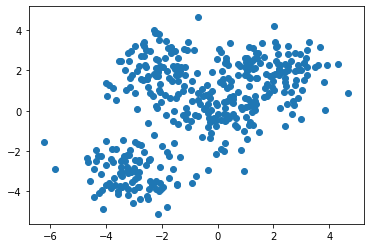

In [3]:
plt.scatter(data[:,0],data[:,1])

In [4]:
class KMeansClassifier():
    
    def __init__(self, k, centers=None):
        # number of clusters
        self.k = k
        # you can provide centers
        self.centers = centers
        # make sure correct number of centers provided
        if self.centers is not None:
            if len(centers) != k:
                raise ValueError('Centers must be array with len k')
                
    def predict(self, x):
        return ((x[:,None,:] - self.centers)**2).sum(axis=-1).argmin(axis=1)
    
    def score(self, x):
        return ((x[:,None,:] - self.centers)**2).sum(axis=-1).min(axis=1).sum()
    
    def train(self, x, return_scores=False):
        
        # start with random centers
        self.centers = np.random.permutation(x)[:self.k]
        
        # initial labels
        labels = -np.ones(len(x))
        labels_new = self.predict(x)
        
        # list of scores
        scores = [self.score(x)]
        
        # loop training until labels don't change
        while np.any(labels != labels_new):
            
            # use new labels
            labels = labels_new
            # calculate new centers
            self.centers = np.array([data[labels == k].mean(axis=0) for k in range(self.k)])
            # generate new labels
            labels_new = self.predict(x)
            
            # save score
            scores.append(self.score(x))
            
        if return_scores:
            return scores

In [29]:
class KMeansClassifier():
    
    def __init__(self, k, centers=None):
        # number of clusters
        self.k = k
        # you can provide centers
        self.centers = centers
        # make sure correct number of centers provided
        if self.centers is not None:
            if len(centers) != k:
                raise ValueError('Centers must be array with len k')
                
    def predict(self, x):
        return ((np.expand_dims(x, axis=1) - self.centers)**2).sum(axis=-1).argmin(axis=1)
    
    def score(self, x):
        return ((np.expand_dims(x, axis=1) - self.centers)**2).sum(axis=-1).min(axis=1).mean()
    
    def train(self, x, return_scores=False):
        
        # start with random centers
        self.centers = self.centers if self.centers is not None else np.random.permutation(x)[:self.k]
        
        # initial labels
        labels = -np.ones(len(x))
        labels_new = self.predict(x)
        
        # list of scores
        scores = [self.score(x)]
        
        # loop training until labels don't change
        while np.any(labels != labels_new):
            
            # use new labels
            labels = labels_new
            # calculate new centers
            self.centers = np.array([x[labels == k].mean(axis=0) for k in range(self.k)])
            # generate new labels
            labels_new = self.predict(x)
            
            # save score
            scores.append(self.score(x))
            
        if return_scores:
            return scores

In [6]:
kmeans = KMeansClassifier(4)

In [7]:
kmeans.train(data)

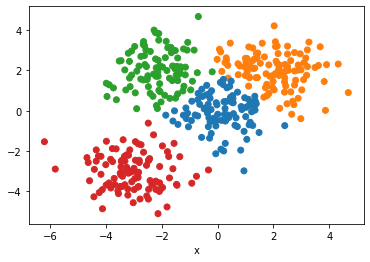

In [8]:
c = [f'C{cluster}' for cluster in kmeans.predict(data)]
plt.scatter(data[:,0], data[:,1], c=c)
plt.xlabel('x')
plt.savefig('kmeans_ex.pdf')

In [11]:
"""from mnist import MNIST

def load_dataset():
    mndata = MNIST('../../../python-mnist/data/')
    X_train, labels_train = map(np.array, mndata.load_training())
    X_test, labels_test = map(np.array, mndata.load_testing())
    X_train = X_train/255.0
    X_test = X_test/255.0
    
    return X_train, labels_train, X_test, labels_test

X_train, Y_train, X_test, Y_test = load_dataset()""";

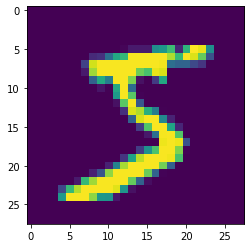

In [12]:
plt.imshow(X_train[0].reshape(28,28))

In [56]:
kmeans = KMeansClassifier(10,x0)
%time scores = kmeans.train(X_train[:10000], return_scores=True)

CPU times: user 11.2 s, sys: 3.34 s, total: 14.5 s
Wall time: 14.6 s


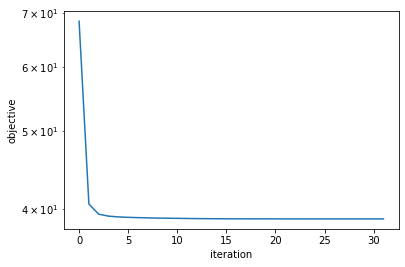

In [40]:
plt.plot(scores)
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('objective')
plt.savefig('A5c_objective.pdf')

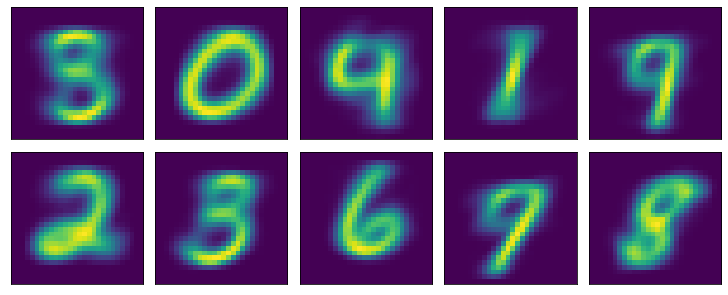

In [42]:
fig, axes = plt.subplots(2, 5, figsize=(10,4), constrained_layout=True)

axes = axes.flatten()

for i,ax in enumerate(axes):
    ax.imshow(kmeans.centers[i].reshape(28,28))
    ax.set(xticks=[],yticks=[])
    
fig.savefig('A5c_centers.pdf')

In [77]:
train_err = dict()
test_err = dict()
for k in [2,4,8,16,32,64]:
    kmeans = KMeansClassifier(k)
    kmeans.train(X_train[:1000])
    train_err[k] = kmeans.score(X_train[:1000])
    test_err[k] = kmeans.score(X_test[:1000])

Text(0, 0.5, 'Error')

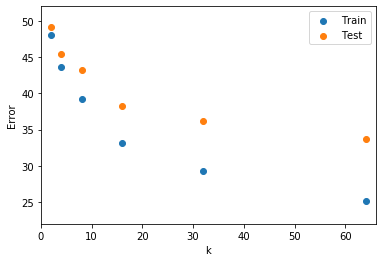

In [78]:
for k in train_err:
    plt.scatter(k, train_err[k], c='C0')
    plt.scatter(k, test_err[k], c='C1')
    
plt.scatter(0, 0, c='C0', label='Train')
plt.scatter(0, 0, c='C1', label='Test')
plt.legend()
    
plt.xlim(0,66)
plt.ylim(22,52)

plt.xlabel('k')
plt.ylabel('Error')

#plt.savefig('A5d.pdf')

## A6

In [190]:
import torch
from torch.nn.functional import relu, cross_entropy
from torch.optim import Adam

In [179]:
from mnist import MNIST

def load_dataset():
    mndata = MNIST('../../../python-mnist/data/')
    X_train, labels_train = map(np.array, mndata.load_training())
    X_test, labels_test = map(np.array, mndata.load_testing())
    X_train = X_train/255.0
    X_test = X_test/255.0
    
    return X_train, labels_train, X_test, labels_test

X_train, Y_train, X_test, Y_test = load_dataset()

X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).long()
X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).long()

In [207]:
def weights(n, m):
    return (2/np.sqrt(m)*torch.rand(size=(n,m)) - 1/np.sqrt(m)).requires_grad_()
def bias(n, m):
    return (2/np.sqrt(m)*torch.rand(size=(n,1)) - 1/np.sqrt(m)).requires_grad_()

In [256]:
%%time
k = 10
d = 784
h = 64

# initialize parameters
W0 = weights(h, d)
b0 = bias(h, d)
W1 = weights(k, h)
b1 = bias(k, h)

# definte the neural network
def F1(x):
    y_hat = torch.matmul(W0, x.T) + b0
    y_hat = relu(y_hat)
    y_hat = torch.matmul(W1, y_hat) + b1
    return y_hat.T

# function to calculate accuracy
def accuracy(y_hat, y):
    return len(y[y_hat.argmax(axis=1) == y]) / len(y)

# make initial predictions
y_hat = F1(X_train)

# initialize Adam optimizer
optim = Adam((W0, b0, W1, b1))

# train until accuracy > 0.99
losses = []
#while accuracy(y_hat, Y_train) < 0.99:
for i in range(1200):

    # predict
    y_hat = F1(X_train)
    # calculate loss
    loss = cross_entropy(y_hat, Y_train)
    losses.append(loss.data.numpy())
    # zero out gradients
    optim.zero_grad()
    # calculate new gradients
    loss.backward()
    # step optimizer forward 
    optim.step()
    
print(len(losses),'epochs')
    
y_hat_test = F1(X_test)
print('test loss ', cross_entropy(y_hat_test, Y_test).data.numpy())
print('test accuracy', accuracy(y_hat_test, Y_test))

# calculate the number of parameters
print('nparams', torch.numel(W0) + torch.numel(b0) + torch.numel(W1) + torch.numel(b1))

1200 epochs
test loss  0.10593045
test accuracy 0.9689
nparams 50890
CPU times: user 7min 26s, sys: 963 ms, total: 7min 27s
Wall time: 1min 51s


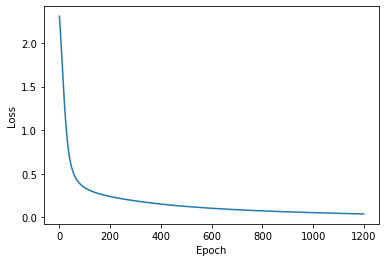

In [257]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.savefig('A6a.pdf')

In [258]:
%%time
k = 10
d = 784
h0 = 32
h1 = 32

# initialize parameters
W0 = weights(h0, d)
b0 = bias(h0, d)
W1 = weights(h1, h0)
b1 = bias(h1, h0)
W2 = weights(k, h1)
b2 = bias(k, h1)

# definte the neural network
def F2(x):
    y_hat = torch.matmul(W0, x.T) + b0
    y_hat = relu(y_hat)
    y_hat = torch.matmul(W1, y_hat) + b1
    y_hat = relu(y_hat)
    y_hat = torch.matmul(W2, y_hat) + b2
    return y_hat.T

# function to calculate accuracy
def accuracy(y_hat, y):
    return len(y[y_hat.argmax(axis=1) == y]) / len(y)

# make initial predictions
y_hat = F2(X_train)

# initialize Adam optimizer
optim = Adam((W0, b0, W1, b1, W2, b2))

# train until accuracy > 0.99
losses = []
#while accuracy(y_hat, Y_train) < 0.99:
for i in range(1200):

    # predict
    y_hat = F2(X_train)
    # calculate loss
    loss = cross_entropy(y_hat, Y_train)
    losses.append(loss.data.numpy())
    # zero out gradients
    optim.zero_grad()
    # calculate new gradients
    loss.backward()
    # step optimizer forward 
    optim.step()
    
print(len(losses),'epochs')
    
y_hat_test = F2(X_test)
print('test loss ', cross_entropy(y_hat_test, Y_test).data.numpy())
print('test accuracy', accuracy(y_hat_test, Y_test))

# calculate the number of parameters
print('nparams', torch.numel(W0) + torch.numel(b0) 
                    + torch.numel(W1) + torch.numel(b1) 
                    + torch.numel(W2) + torch.numel(b2))

1200 epochs
test loss  0.13459158
test accuracy 0.9636
nparams 26506
CPU times: user 5min 13s, sys: 1.05 s, total: 5min 14s
Wall time: 1min 18s


Text(0, 0.5, 'Loss')

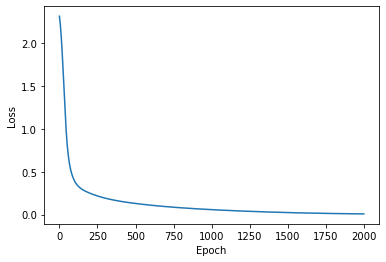

In [246]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.savefig('A6b.pdf')

## A7

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from mnist import MNIST

def load_dataset():
    mndata = MNIST('../../../python-mnist/data/')
    X_train, labels_train = map(np.array, mndata.load_training())
    X_test, labels_test = map(np.array, mndata.load_testing())
    X_train = X_train/255.0
    X_test = X_test/255.0
    
    return X_train, labels_train, X_test, labels_test

X_train, Y_train, X_test, Y_test = load_dataset()

X_train = X_train[:50000]
Y_train = Y_train[:50000]
X_test = X_test[:10000]
Y_test = Y_test[:10000]

In [3]:
mu = X_train.mean(axis=0)
Sigma_train = 1/50000 * (X_train - mu).T @ (X_train - mu)

In [4]:
evals = np.linalg.eigvalsh(Sigma_train)[::-1]
print(evals[[0,1,9,29,49]])
print(evals.sum())

[5.14833344 3.72998949 1.25001076 0.36492648 0.16962132]
52.83384400094488


In [5]:
evals, evecs = np.linalg.eigh(Sigma_train)
evals, evecs = evals[::-1], evecs[:,::-1]

In [6]:
eigproj = lambda X, k: mu + (evecs[:,:k] @ (evecs[:,:k].T @ (X - mu).T)).T
recon_err = lambda X, k: ((X - eigproj(X, k))**2).sum(axis=1).mean()
k = np.arange(1,101)
train_errs = [recon_err(X_train, ki) for ki in k]
test_errs = [recon_err(X_test, ki) for ki in k]

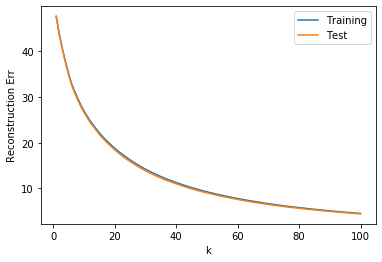

In [7]:
plt.plot(k, train_errs, label='Training')
plt.plot(k, test_errs, label='Test')
plt.legend()
plt.xlabel('k')
plt.ylabel('Reconstruction Err')
plt.savefig('A7c_err.pdf')

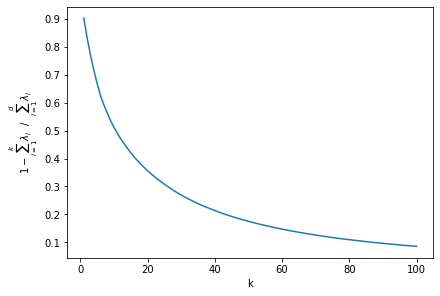

In [8]:
fig,ax = plt.subplots(constrained_layout=True)
ax.plot(k, [1 - evals[:ki].sum()/evals.sum() for ki in k])
ax.set_xlabel('k')
ax.set_ylabel('$1 - \sum_{i=1}^k \lambda_i ~~ / ~~ \sum_{i=1}^d \lambda_i$')
fig.savefig('A7c_evals.pdf')

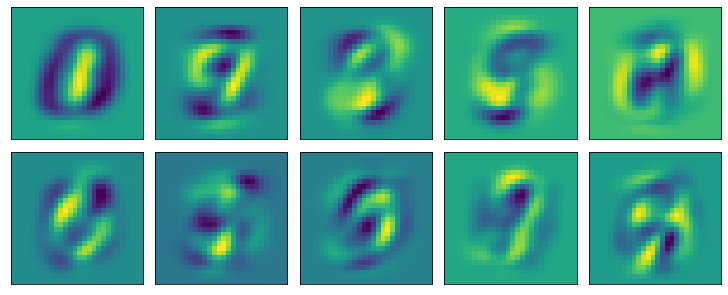

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(10,4), constrained_layout=True)

axes = axes.flatten()

for i,ax in enumerate(axes):
    ax.imshow(evecs[:,i].reshape(28,28))
    ax.set(xticks=[],yticks=[])
    
plt.savefig('A7d.pdf')

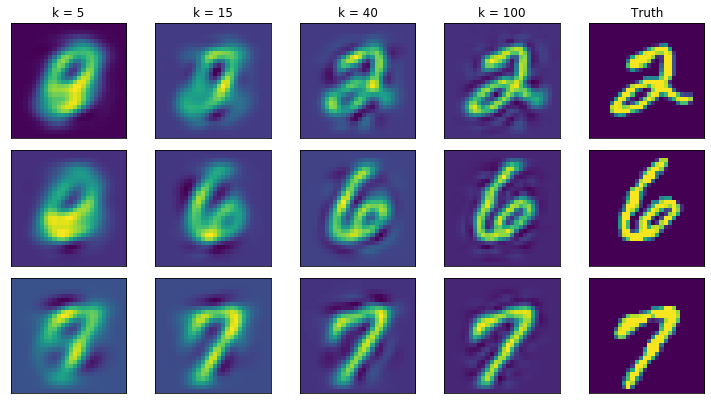

In [30]:
fig, axes = plt.subplots(3, 5, figsize=(10,5.5), constrained_layout=True)

yidx = [5,13,15]
k = [5,15,40,100]

for i,yi in enumerate(yidx):
    for j,ax in enumerate(axes[i,:-1]):
        xproj = eigproj(X_train[yi], k[j])
        ax.imshow(xproj.reshape(28,28))
        if i == 0:
            ax.set_title(f'k = {k[j]}')
    axes[i,-1].imshow(X_train[yi].reshape(28,28))
    
axes[0,-1].set_title('Truth')

for i,ax in enumerate(axes.flatten()):
    ax.set(xticks=[],yticks=[])
    
fig.savefig('A7e.pdf')

In [1]:
!pwd

/home/jfcrenshaw/documents/uw/cse546/hw3/code
